In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/plant-seedlings/"

In [4]:
sz = 224
arch = resnet101
bs = 58
# try 224, 58 and 299, 58

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [6]:
label_df = pd.read_csv(label_csv)

## Removing space between class names

In [ ]:
label_df.species = label_df.species.apply(lambda x: re.sub(' ', '_', x))
label_df.to_csv(f'{PATH}labels.csv', index=False)

## Pivot table

In [ ]:
label_df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

## Analysis

In [ ]:
row_sz = [PIL.Image.open(f'{PATH}train/'+k).size[0] for k in os.listdir(f'{PATH}train/')]

In [ ]:
col_sz = [PIL.Image.open(f'{PATH}train/'+k).size[1] for k in os.listdir(f'{PATH}train/')]

In [ ]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [ ]:
plt.hist(row_sz[row_sz < 500]);

In [ ]:
plt.hist(col_sz[col_sz < 500]);

## Training setup

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [8]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 14/14 [00:32<00:00,  2.35s/it]


In [10]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|████████▋ | 57/66 [00:03<00:00, 16.36it/s, loss=10.3]


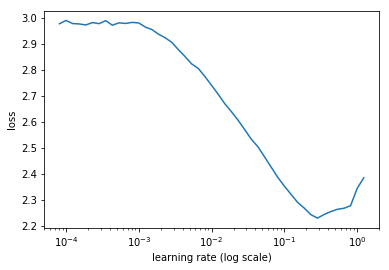

In [11]:
learn.sched.plot()

In [12]:
lr = 1e-2

In [13]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       1.4472   0.91074  0.72027]                     
[ 1.       1.01093  0.58808  0.81864]                     
[ 2.       0.7731   0.55296  0.83109]                      
[ 3.       0.68423  0.49568  0.82842]                      
[ 4.       0.60686  0.44555  0.8534 ]                      
[ 5.       0.52205  0.42127  0.85377]                      
[ 6.       0.48486  0.41109  0.86013]                      



In [14]:
lrs = np.array([lr/9,lr/3,lr])

In [15]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.56132  0.41238  0.85746]                      
[ 1.       0.54479  0.3959   0.86557]                      
[ 2.       0.51712  0.37974  0.86926]                      
[ 3.       0.53423  0.40181  0.85506]                      
[ 4.       0.49791  0.36133  0.87572]                      
[ 5.       0.46582  0.34718  0.87839]                      
[ 6.       0.45863  0.35481  0.87166]                      



In [16]:
sz = 299

In [17]:
learn.set_data(get_data(sz, 32))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [18]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.51843  0.30646  0.89972]                        
[ 1.       0.52206  0.31569  0.88504]                        
[ 2.       0.46239  0.28807  0.91155]                        
[ 3.       0.49778  0.3246   0.87926]                        
[ 4.       0.45653  0.28787  0.89858]                        
[ 5.       0.40266  0.25977  0.91203]                        
[ 6.       0.36433  0.26029  0.90994]                        



In [19]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.39223  0.17465  0.93437]                        
[ 1.       0.28082  0.19909  0.92301]                        
[ 2.       0.15484  0.11091  0.96307]                        
[ 3.       0.15541  0.24931  0.91364]                        
[ 4.       0.11136  0.12     0.96098]                        
[ 5.       0.06625  0.08765  0.97036]                         
[ 6.       0.04995  0.07828  0.975  ]                         



In [ ]:
sz = 128

In [20]:
from sklearn import metrics

In [ ]:
learn.set_data(get_data(sz, bs))

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn

In [ ]:
learn.fit(lr, 2, cycle_len=2)

In [ ]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz = 224

In [ ]:
learn.set_data(get_data(sz, 58))

In [ ]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz = 299

In [ ]:
learn.set_data(get_data(sz, 58))

In [ ]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [21]:
learn.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.38284  0.42656  0.85691]                        
[ 1.       0.16479  0.16221  0.94224]                        
[ 2.       0.1899   0.22955  0.92197]                        
[ 3.       0.10359  0.11305  0.96411]                         



In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.load(f'{sz}')

## Old steps

In [ ]:
learn.set_data(get_data(299, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('299_r50')

In [ ]:
learn.load('299_r50')

In [ ]:
learn.set_data(get_data(350, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('350_r50')

In [ ]:
learn.load('350_r50')

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)

In [ ]:
accuracy(log_preds, y)

In [ ]:
metrics.f1_score()

In [ ]:
learn.save('350_r50')

## Prediction

In [22]:
log_preds, y = learn.TTA(is_test=True)
probs_299 = np.exp(log_preds)

In [23]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()

In [24]:
save_array('probs_299.bc', probs_299)

## Save to file for submission

In [25]:
def load_array(fname): return bcolz.open(fname)[:]

In [ ]:
probs_350 = load_array('probs_350.bc')

In [ ]:
probs = (probs_350 + probs_450) / 2

In [ ]:
data.classes

In [26]:
df = pd.DataFrame(np.argmax(probs_299, axis=1))

In [27]:
df.insert(0, 'file', [o[5:-4] for o in data.test_ds.fnames])

In [28]:
df.columns = ['file', 'species']

In [29]:
df.species = df.species.apply(lambda x: data.classes[x])

In [30]:
df.species = df.species.apply(lambda x: re.sub('_', ' ', x))

In [31]:
df.file = df.file.apply(lambda x: str(x) + '.png')

In [32]:
SUBM = f'{PATH}results/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}submission5.csv', index=False)
#df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)